In [360]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from stock_utils import eng_features

### read data and engineer features

In [362]:
#read data
alpha = pd.read_csv("data/QQQ_daily.csv")
omega = pd.read_csv("data/SPY_daily.csv")

#performance features
alpha['high_adj'] = (alpha['High'] - alpha['Close']) / alpha['Close']
alpha['low_adj'] = (alpha['Low'] - alpha['Close']) / alpha['Close']
alpha['body'] = (alpha['Close'] - alpha['Open']) / alpha['Open']

#return features
alpha['close_prev'] = alpha['Close'].shift(1)
alpha['close_next'] = alpha['Close'].shift(-1)
alpha['close_next_3_days'] = alpha['Close'].shift(-3)
alpha['close_prev_3_days'] = alpha['Close'].shift(3)
alpha['close_prev_week'] = alpha['Close'].shift(7)
alpha['close_next_week'] = alpha['Close'].shift(-7)

alpha['change'] = (alpha['Close'] - alpha['close_prev']) / alpha['close_prev']

#future performance
alpha['change_next'] = (alpha['close_next'] - alpha['Close']) / alpha['Close']
alpha['change_next_3_days'] = (alpha['close_next_3_days'] - alpha['Close']) / alpha['Close']
alpha['change_next_week'] = (alpha['close_next_week'] - alpha['Close']) / alpha['Close']

#past performance
alpha['change_prev_3_days'] = (alpha['Close'] - alpha['close_prev_3_days']) / alpha['close_prev_3_days']

#MA features
alpha['ma_7'] = alpha['Close'].rolling(window=7).mean()
alpha['ma_3'] = alpha['Close'].rolling(window=3).mean()
alpha['ma_200'] = alpha['Close'].rolling(window=200).mean()

#macro trend (above longer term MA)
omega['ma_200'] = omega['Close'].rolling(window=200).mean()
omega['macro_uptrend'] = omega['ma_200'] < omega['Close']
omega['macro_uptrend'] = omega['macro_uptrend'].apply(lambda x: 1 if x else 0)
omega['pct_above_ma_200'] = (omega['Close'] - omega['ma_200']) / omega['Close']

#micro trend (above shorter term MA)
alpha['pct_above_ma_7'] = (alpha['Close'] - alpha['ma_7']) / alpha['Close']
alpha['pct_above_ma_3'] = (alpha['Close'] - alpha['ma_3']) / alpha['Close']

#normalized MA slopes
alpha['ma_7_prev'] = alpha['ma_7'].shift(1) 
alpha['ma_7_change'] = (alpha['ma_7'] - alpha['ma_7_prev']) / alpha['ma_7_prev']
alpha['ma_3_prev'] = alpha['ma_3'].shift(1) 
alpha['ma_3_change'] = (alpha['ma_3'] - alpha['ma_3_prev']) / alpha['ma_3_prev']

#combine macro trends
omega = omega[['Date', 'macro_uptrend', 'pct_above_ma_200']]
alpha = pd.merge(alpha, omega, how='inner', on='Date')

#create labels
alpha['z_change_next_3_days'] = (alpha['change_next_3_days'] - alpha['change_next_3_days'].mean()) / alpha['change_next_3_days'].std()
alpha['z_change_next_3_days'] = np.rint(alpha['z_change_next_3_days'])
alpha['z_change_next_3_days'] = alpha['z_change_next_3_days'].apply(lambda x: -1 if x <= -1 else 1)


### visualize labels

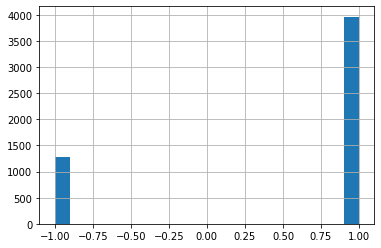

In [363]:
alpha['z_change_next_3_days'].hist(bins=20)

In [364]:
alpha = alpha.dropna()
cols = ['high_adj', 'low_adj', 'body',
        'change', 'change_prev_3_days',
        'macro_uptrend',
        'pct_above_ma_200', 'pct_above_ma_7', 'pct_above_ma_3',
        'ma_7_change', 'ma_3_change']

X = np.asanyarray(alpha[cols])
y = np.asanyarray(alpha['z_change_next_3_days'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [365]:
clf = RandomForestClassifier(max_depth=5, random_state=1)
clf = clf.fit(X_train, y_train)
yhat = clf.predict(X_test)

/Users/alexdoria/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [366]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

          -1       0.40      0.02      0.03       239
           1       0.76      0.99      0.86       768

    accuracy                           0.76      1007
   macro avg       0.58      0.50      0.45      1007
weighted avg       0.68      0.76      0.67      1007



### evalute model

In [376]:
ev = pd.DataFrame(X_test, columns=cols)
ev['predicted'] = yhat
ev['actual'] = y_test

In [383]:
ev[ev['predicted'] == -1]

,high_adj,low_adj,body,change,change_prev_3_days,macro_uptrend,pct_above_ma_200,pct_above_ma_7,pct_above_ma_3,ma_7_change,ma_3_change,predicted,actual
231,0.024992,-0.029259,0.022756,0.007369,0.109946,0.0,-0.025274,0.054644,0.023265,0.018005,0.034988,-1,-1
276,0.004615,-0.081538,0.087866,0.081531,0.037510,0.0,-0.052350,0.009670,0.042308,-0.007708,0.012744,-1,-1
430,0.060703,-0.011502,-0.011058,0.009677,0.089453,0.0,-0.142095,0.059881,0.029606,0.007829,0.029023,-1,1
610,0.012014,-0.046643,0.039677,0.061117,0.053611,0.0,-0.461452,0.025341,0.051472,-0.011063,0.018207,-1,1
686,0.010658,-0.034483,0.033477,0.044076,0.069752,0.0,-0.030664,0.032691,0.026611,-0.006287,0.022839,-1,1
737,0.008575,-0.030216,0.003689,0.019355,0.084828,0.0,-0.064532,0.061774,0.025589,0.012050,0.027485,-1,-1
837,0.001232,-0.044421,0.041717,0.026499,-0.033639,1.0,0.058789,-0.022030,0.003881,-0.007369,-0.011514,-1,-1
970,0.036585,-0.013415,-0.027514,0.030151,0.140473,0.0,-0.170950,0.094704,0.041870,0.014050,0.044769,-1,1
979,0.004717,-0.091195,0.060000,0.062657,-0.026779,1.0,0.005300,-0.047844,0.010744,-0.014888,-0.009186,-1,1
988,0.003909,-0.037351,0.011199,0.029510,-0.001518,0.0,-0.049182,-0.020226,0.021281,-0.014533,-0.000517,-1,1


In [381]:
ev[ev['predicted'] == -1]['macro_uptrend'].value_counts()

0.0    8
1.0    2
Name: macro_uptrend, dtype: int64